# Exploratory Data Analysis of Titanic Data with SingleStoreDB

This notebook uses the SingleStoreDB Python package to perform basic EDA for the Titanic survival data.
The **new No SQL** --> No Can See SQL.

In [1]:
import ibis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ibis.options.verbose = False   ## make this True to see the generated SQL
ibis.options.interactive = True

### Connect to SingleStoreDB

The connection parameters can either be [Python DB-API](https://peps.python.org/pep-0249/) style parameters, 
or a URL connection string as used by [SQLAlchemy](https://www.sqlalchemy.org).

In [3]:
conn = ibis.singlestoredb.connect('root:@127.0.0.1/x_db')

### Head over to Kaggle and get the csv files for the titanic data

https://www.kaggle.com/c/titanic

### Read the csv files for training and test data set 

- Pclass = Passenger Class (1=1st, 2=2nd, 3=3rd)
- Survived = Survival (1 = Yes, 0 = No)
- Sex = Gender
- Age = Passenger age
- Fare = Ticket price in British pounds
- SibSp  = # of siblings / spouses aboard the Titanic. 
- Parch  = # of parents / children aboard the Titanic.
- Embarked = Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
- Cabin = Cabin No.

In [4]:
train_df = pd.read_csv('titanic_train.csv')
test_df = pd.read_csv('titanic_test.csv')

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
titanic_df = pd.concat([train_df, test_df])

### Create a table for the combined data in SingleStoreDB

We can use the `create_table` method of the connection to upload a pandas DataFrame to a database table.
The `force=True` is merely used here in case you run the same notebook multiple times. It will cause the 
table in the database to be overwritten if it already exists.

In [8]:
titanic_tbl = conn.create_table('titanic', titanic_df, force=True)

In [9]:
titanic_tbl.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [10]:
titanic_tbl.info()

                     Summary of titanic                     
                         1309 rows                          
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓
┃ Name        ┃ Type                   ┃ # Nulls ┃ % Nulls ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩
│ PassengerId │ Int64(nullable=True)   │       0 │    0.00 │
│ Survived    │ Float64(nullable=True) │     418 │   31.93 │
│ Pclass      │ Int64(nullable=True)   │       0 │    0.00 │
│ Name        │ String(nullable=True)  │       0 │    0.00 │
│ Sex         │ String(nullable=True)  │       0 │    0.00 │
│ Age         │ Float64(nullable=True) │     263 │   20.09 │
│ SibSp       │ Int64(nullable=True)   │       0 │    0.00 │
│ Parch       │ Int64(nullable=True)   │       0 │    0.00 │
│ Ticket      │ String(nullable=True)  │       0 │    0.00 │
│ Fare        │ Float64(nullable=True) │       1 │    0.08 │
│ Cabin       │ String(nullable=True)  │    1014 │   77.46 │
│ Embarked    │ String(n

### List of Ibis functions for numerical data

We will be using various methods on numeric columns of database tables in this notebook. This code simply
prints all of the methods on numeric columns for reference.

In [11]:
num_expr = titanic_tbl.Survived
print(' '.join([x for x in dir(num_expr) if not x.startswith('_')]))

abs acos add approx_median approx_nunique arbitrary argmax argmin asin atan atan2 between bottomk bucket case cases cast ceil clip coalesce collect compile corr cos cot count cov cume_dist cummax cummean cummin cumsum deg2rad degrees dense_rank describe div equals execute exp fillna first floor floordiv get_name greatest group_concat has_name hash histogram identical_to isin isinf isnan isnull lag last lead least ln log log10 log2 max mean min mod mul name negate notin notnull nth ntile nullif nullifzero nunique op over parent percent_rank pipe point pow quantile rad2deg radd radians rank rdiv rfloordiv rmod rmul round rpow rsub sign sin sqrt std sub substitute sum summary tan to_projection topk type typeof value_counts var verify visualize zeroifnull


### Unique values for some columns in the table

In [12]:
titanic_tbl['Pclass', 'Sex', 'Ticket'].describe(stats=['unique'], include='all')  # Use include='all' to include character columns in statistics

,name,unique
0,Pclass,3
1,Sex,2
2,Ticket,929


### Simple statistics for numeric columns

In [13]:
titanic_tbl['SibSp', 'Parch', 'Age'].describe(stats=['min', 'mean', 'max'])

,name,mean,min,max
0,SibSp,0.498900,0,8
1,Parch,0.385000,0,9
2,Age,29.881138,0.17000000178813934,80


#### Set the verbose option to True if you want to see the generated SQL

In [14]:
ibis.options.verbose = False

### Overall Survival Rate

In [15]:
train = titanic_tbl.Survived.notnull()
cond = titanic_tbl.Survived == 1
num_surv = titanic_tbl[cond].count()
num_pass = titanic_tbl[train].count()
num_surv / num_pass

0.3838383838

### Cross-classification of Gender and Survival

In [16]:
cols = [titanic_tbl.Sex, titanic_tbl.Survived]
train = titanic_tbl.Survived.notnull()

freq = titanic_tbl[train].groupby(cols).aggregate([
    titanic_tbl.count().name('Passengers'),
    titanic_tbl.Age.mean().name('Avg Age')
]).sort_by(cols)
freq

,Sex,Survived,Passengers,Avg Age
0,female,0.0,81,25.046875
1,female,1.0,233,28.847716
2,male,0.0,468,31.618056
3,male,1.0,109,27.276022


#### Join with the gender-specific counts

In [17]:
gender = titanic_tbl[train].groupby(titanic_tbl.Sex).count(metric_name='Count')
joined = freq.join(gender, freq.Sex == gender.Sex, suffixes=('', '_')).drop('Sex_')
joined

,Sex,Survived,Passengers,Avg Age,Count
0,female,0.0,81,25.046875,314
1,female,1.0,233,28.847716,314
2,male,0.0,468,31.618056,577
3,male,1.0,109,27.276022,577


#### Calculate the percentages overall and within each gender

In [18]:
# Get the total as a local numeric to use in the following expressions.
# Downloading the value is needed because it originates from a separate table expression.
total = titanic_tbl[train].count().execute()

# Add additional columns to joined table and execute to download the data for plotting.
joined = joined[
    joined.columns + [
        (100.0 * joined.Passengers / total).name('Overall Percent'),
        (100.0 * joined.Passengers / joined.Count).name('Group Percent'),
    ]
]
joined

,Sex,Survived,Passengers,Avg Age,Count,Overall Percent,Group Percent
0,female,0.0,81,25.046875,314,9.090909,25.796178
1,female,1.0,233,28.847716,314,26.150393,74.203822
2,male,0.0,468,31.618056,577,52.525253,81.109185
3,male,1.0,109,27.276022,577,12.233446,18.890815


#### Draw a nested barplot by sex and survival

Plotting the data requires us to download the data into a pandas `DataFrame`. The `execute` method is used to 
execute the query behind the `joined` object and return a local `DataFrame` of the values.

In [19]:
joined = joined.execute()

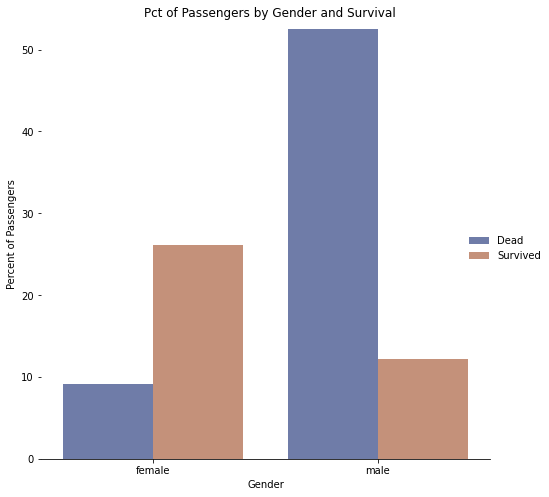

In [20]:
g = sns.catplot(
    data=joined, kind='bar',
    x='Sex', y='Overall Percent', hue='Survived',
    palette='dark', alpha=.6, height=7
)

g.despine(left=True)
g.set_axis_labels('Gender', 'Percent of Passengers')
g.legend.set_title('')

new_labels = ['Dead', 'Survived']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)
    
g.fig.suptitle('Pct of Passengers by Gender and Survival');

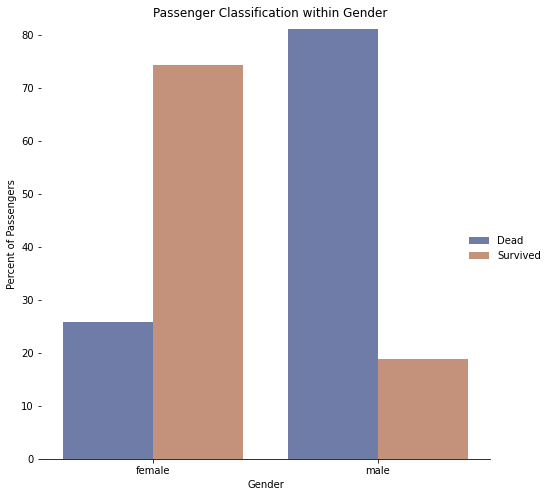

In [21]:
g = sns.catplot(
    data=joined, kind='bar',
    x='Sex', y='Group Percent', hue='Survived',
    palette='dark', alpha=.6, height=7
)

g.despine(left=True)
g.set_axis_labels('Gender', 'Percent of Passengers')
g.legend.set_title('')

new_labels = ['Dead', 'Survived']
for t, l in zip(g.legend.texts, new_labels):
    t.set_text(l)

g.fig.suptitle('Passenger Classification within Gender');

### Survival by Passenger Class

In [22]:
cols = [titanic_tbl.Pclass, titanic_tbl.Survived]
train = titanic_tbl.Survived.notnull()

freq = titanic_tbl[train].groupby(cols).aggregate([
    titanic_tbl.count().name('Passengers'),
    titanic_tbl.Age.mean().name('Avg Age')
]).sort_by(cols)
freq

,Pclass,Survived,Passengers,Avg Age
0,1,0.0,80,43.695312
1,1,1.0,136,35.368197
2,2,0.0,97,33.544444
3,2,1.0,87,25.901566
4,3,0.0,372,26.555556
5,3,1.0,119,20.646118


In [23]:
passenger = titanic_tbl[train].groupby(titanic_tbl.Pclass).count(metric_name='Count')
joined = freq.join(passenger, freq.Pclass == passenger.Pclass, suffixes=('', '_')).drop('Pclass_')

# Construct columns for joined table and execute to download data for plotting
joined = joined[
    joined.columns + [
    (100.0 * joined.Passengers / total).name('Overall Percent'),
    (100.0 * joined.Passengers / joined.Count).name('Group Percent')
    ]
]
joined

,Pclass,Survived,Passengers,Avg Age,Count,Overall Percent,Group Percent
0,1,0.0,80,43.695312,216,8.978676,37.037037
1,1,1.0,136,35.368197,216,15.263749,62.962963
2,2,0.0,97,33.544444,184,10.886644,52.717391
3,2,1.0,87,25.901566,184,9.764310,47.282609
4,3,0.0,372,26.555556,491,41.750842,75.763747
5,3,1.0,119,20.646118,491,13.355780,24.236253


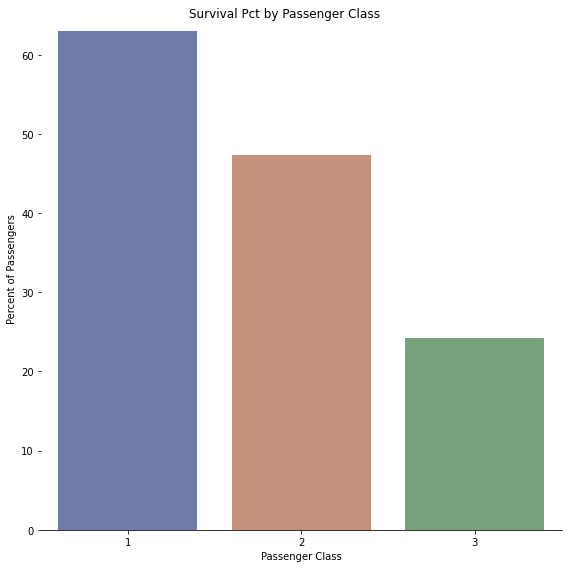

In [24]:
joined = joined.execute()

cond = joined.Survived == 1.

g = sns.catplot(
    data=joined[cond], 
    kind='bar',
    x='Pclass', y='Group Percent',
    palette='dark', alpha=.6, height=8
)

g.despine(left=True)
g.set_axis_labels('Passenger Class', 'Percent of Passengers')
g.fig.suptitle('Survival Pct by Passenger Class');

### Analyze Age Groups

In [25]:
buckets = [-10, 0, 10, 20, 30, 40, 50, 60, 70, 80]

bucketed = titanic_tbl.Age.bucket(buckets).name('Age Group').value_counts(metric_name='Count').sort_by('Age Group')

labeled_bucket = bucketed['Age Group'].label(
    ['None', '< 10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
).name('Ages')

expr = bucketed[labeled_bucket, bucketed].sort_by('Age Group').execute()
total = expr.Count.sum()

expr['Percent'] = 100.0 * expr.Count / total
expr

,Ages,Age Group,Count,Percent
0,None,NaN,263,20.091673
1,< 10,1.0,82,6.264324
2,11-20,2.0,143,10.924370
3,21-30,3.0,344,26.279603
4,31-40,4.0,232,17.723453
5,41-50,5.0,135,10.313216
6,51-60,6.0,70,5.347594
7,61-70,7.0,32,2.444614
8,71-80,8.0,8,0.611154


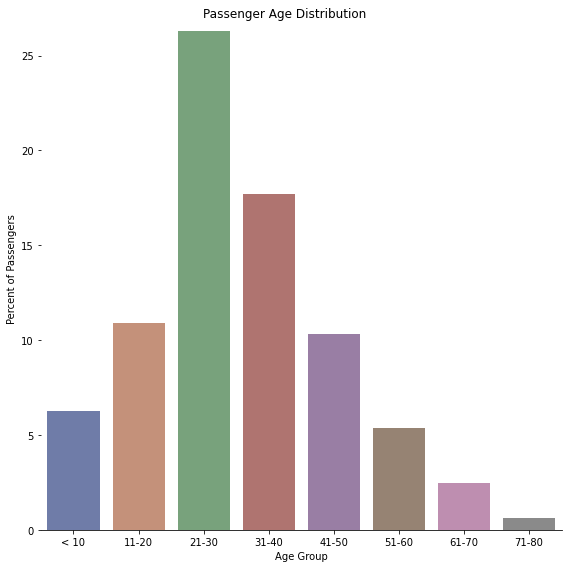

In [26]:
g = sns.catplot(
    data=expr, 
    kind='bar',
    x='Ages', y='Percent',
    palette='dark', alpha=.6, height=8
)

g.despine(left=True)
g.set_axis_labels('Age Group', 'Percent of Passengers')
g.fig.suptitle('Passenger Age Distribution');

In [27]:
buckets = [-10,0,10,20,30,40,50,60,70,80]

cond = titanic_tbl.Survived == 1

bucketed = titanic_tbl[cond].Age.bucket(buckets).name('Age Group').value_counts(metric_name='Count').sort_by('Age Group')

labeled_bucket = bucketed['Age Group'].label(
    ['NaN', '< 10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
).name('Ages')

expr = bucketed[labeled_bucket, bucketed].sort_by('Age Group').execute()
total = expr.Count.sum()
expr['Percent'] = 100.0 * expr.Count / total

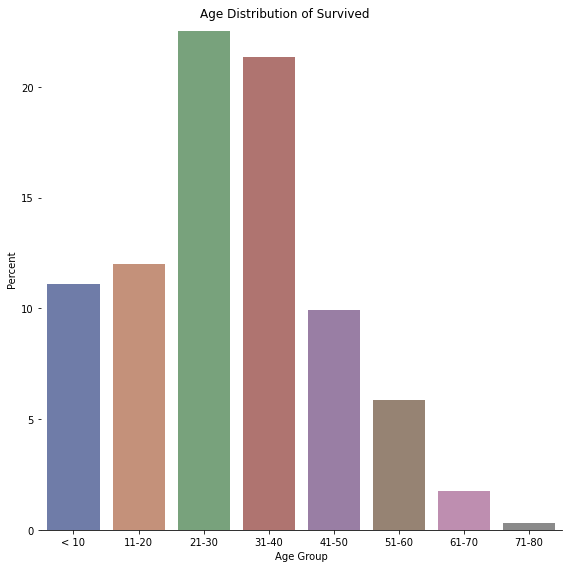

In [28]:
g = sns.catplot(
    data=expr, 
    kind='bar',
    x='Ages', y='Percent',
    palette='dark', alpha=.6, height=8
)

g.despine(left=True)
g.set_axis_labels('Age Group', 'Percent')
g.fig.suptitle('Age Distribution of Survived');